### Note on project

In [1]:
#necessary imports for data collection and visualization
import requests,json
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

#import for country code
import country_converter as coco
import pycountry

#additional imports
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
init_notebook_mode(connected=True)

## Obtain Data

In [2]:
response = json.loads(requests.get("https://opendata.ecdc.europa.eu/covid19/casedistribution/json/").text)

In [3]:
print(type(response))

<class 'dict'>


In [4]:
print(response.keys())

dict_keys(['records'])


In [5]:
print(len(response['records']))

43300


In [6]:
#load dataframe
data = pd.DataFrame(response['records'])

In [7]:
data.head(10)

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2019,continentExp,Cumulative_number_for_14_days_of_COVID-19_cases_per_100000
0,17/09/2020,17,09,2020,17,0,Afghanistan,AF,AFG,38041757.0,Asia,1.65344624
1,16/09/2020,16,09,2020,40,10,Afghanistan,AF,AFG,38041757.0,Asia,1.70864874
2,15/09/2020,15,09,2020,99,6,Afghanistan,AF,AFG,38041757.0,Asia,1.62715933
3,14/09/2020,14,09,2020,75,0,Afghanistan,AF,AFG,38041757.0,Asia,1.45629446
4,13/09/2020,13,09,2020,35,0,Afghanistan,AF,AFG,38041757.0,Asia,1.3090878
5,12/09/2020,12,09,2020,34,0,Afghanistan,AF,AFG,38041757.0,Asia,1.22496971
6,11/09/2020,11,09,2020,28,0,Afghanistan,AF,AFG,38041757.0,Asia,1.16450983
7,10/09/2020,10,09,2020,24,2,Afghanistan,AF,AFG,38041757.0,Asia,1.09879257
8,09/09/2020,09,09,2020,26,3,Afghanistan,AF,AFG,38041757.0,Asia,1.18028197
9,08/09/2020,08,09,2020,96,3,Afghanistan,AF,AFG,38041757.0,Asia,1.11456471


## Data Cleaning

In [8]:
#change to datetime format
data['dateRep'] = pd.to_datetime(data['dateRep'], infer_datetime_format=True)

In [9]:
#check column type
data['dateRep'].dtype

dtype('<M8[ns]')

In [10]:
#check for unique month column
data['dateRep'].dt.month.unique()

array([ 9,  8,  7,  6,  5,  4,  3,  2,  1, 12])

In [11]:
#change to string for a different time format
data['dateRep'] = data['dateRep'].dt.strftime('%d-%b-%Y')

In [12]:
data['dateRep'].head()

0    17-Sep-2020
1    16-Sep-2020
2    15-Sep-2020
3    14-Sep-2020
4    13-Sep-2020
Name: dateRep, dtype: object

In [13]:
data.shape

(43300, 12)

In [14]:
#quick info on the data 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43300 entries, 0 to 43299
Data columns (total 12 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   dateRep                                                     43300 non-null  object 
 1   day                                                         43300 non-null  object 
 2   month                                                       43300 non-null  object 
 3   year                                                        43300 non-null  object 
 4   cases                                                       43300 non-null  int64  
 5   deaths                                                      43300 non-null  int64  
 6   countriesAndTerritories                                     43300 non-null  object 
 7   geoId                                                       43300 non-null  object 
 

In [15]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cases,43300.0,6.905886e+02,4.303682e+03,-8261.0,0.0,9.0,147.0,9.789400e+04
deaths,43300.0,2.173882e+01,1.264970e+02,-1918.0,0.0,0.0,3.0,4.928000e+03
popData2019,43236.0,4.293025e+07,1.580210e+08,815.0,1355982.0,8519373.0,29161922.0,1.433784e+09


In [16]:
#checking for number of uniqe territories, and country code
data[['countriesAndTerritories', 'geoId', 'countryterritoryCode', 'continentExp']].nunique()

countriesAndTerritories    210
geoId                      210
countryterritoryCode       209
continentExp                 6
dtype: int64

## Exploratory Data analysis

***

### Global reported number of cases and deaths till date

In [17]:
global_df = pd.DataFrame(data[['cases', 'deaths']].sum()).transpose()
global_df['Mortality rate (per 100)'] = np.round(100*global_df["deaths"]/global_df["cases"],2)
global_df = global_df.rename({0: 'Global'})
global_df.style.background_gradient(cmap='RdYlBu',axis=1).format("{:.2f}").format("{:.0f}",subset=["cases","deaths"])

,cases,deaths,Mortality rate (per 100)
Global,29902487,941291,3.15


### Covid 19 cases in each continent

Text(0, 0.5, 'Total number of people with confirmed cases/Death (in million)')

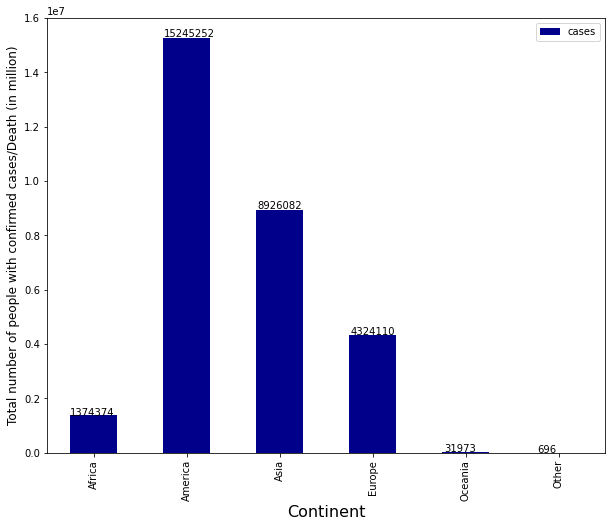

In [18]:
cases_and_death_in_each_continent = data.groupby('continentExp')[['cases']].sum()
ax = cases_and_death_in_each_continent[['cases']].plot(kind='bar', figsize = (10, 8), color = 'darkblue')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
plt.xlabel('Continent', fontsize = 16)
plt.ylabel('Total number of people with confirmed cases/Death (in million)', fontsize = 12)

### Covid 19 death in each continent

In [19]:
#n
death_and_cases_per_continent = data.groupby('continentExp')['cases', 'deaths'].sum()


In [20]:
death_and_cases_per_continent['Mortality Rate (per 100)'] = np.round(100 * death_and_cases_per_continent['deaths']/death_and_cases_per_continent['cases'], 2)

In [21]:
death_and_cases_per_continent.sort_values('cases', ascending = False).style.background_gradient(cmap='Blues', subset=['cases'])\
                        .background_gradient(cmap='Reds',subset=["deaths"])\
                        .background_gradient(cmap='YlOrBr',subset=["Mortality Rate (per 100)"])\


,cases,deaths,Mortality Rate (per 100)
continentExp,,,
America,15245252,522420,3.430000
Asia,8926082,168723,1.890000
Europe,4324110,216005,5.000000
Africa,1374374,33246,2.420000
Oceania,31973,890,2.780000
Other,696,7,1.010000


Text(0.5, 1.0, 'Total deaths in each continent')

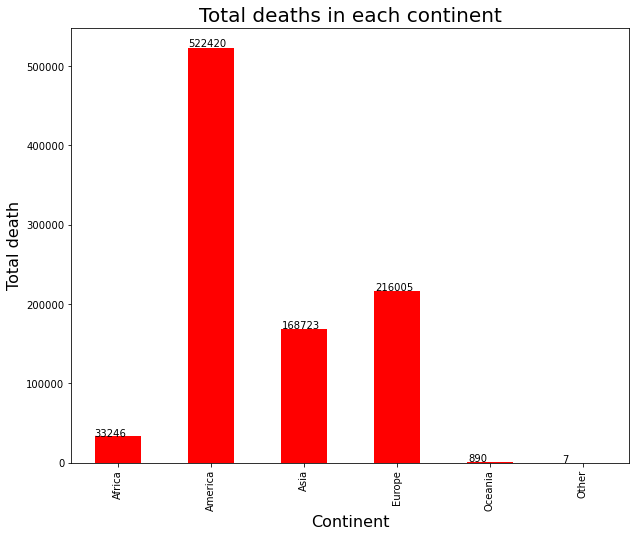

In [22]:
#check for number of de
plt.figure(figsize=(10, 8))
ax2 = data.groupby('continentExp')['deaths'].sum().plot(kind='bar', color = 'red')
for p2 in ax2.patches:
    ax2.annotate(str(p2.get_height()), (p2.get_x() * 1.005, p2.get_height() * 1.005))
plt.xlabel('Continent', fontsize = 16)
plt.ylabel('Total death', fontsize = 16)
plt.title('Total deaths in each continent', fontsize=20)

##### The America continent has the total number of death

### Trend of covid19 death trend in each continent

In [23]:
#convert initial columns of date, year, and month to datetime object
data['day'] = data['dateRep'].apply(lambda x: int(x.split('-')[0]))
data['month'] = data['dateRep'].apply(lambda x: x.split('-')[1])
data['year'] = data['dateRep'].apply(lambda x: int(x.split('-')[2]))

In [24]:
#check data type
data.dtypes

dateRep                                                        object
day                                                             int64
month                                                          object
year                                                            int64
cases                                                           int64
deaths                                                          int64
countriesAndTerritories                                        object
geoId                                                          object
countryterritoryCode                                           object
popData2019                                                   float64
continentExp                                                   object
Cumulative_number_for_14_days_of_COVID-19_cases_per_100000     object
dtype: object

In [25]:
#pivot table to get the number of deaths in each month relative to each continent
deaths_per_month_per_continent = pd.pivot_table(data = data, values = 'deaths', index = 'month', columns = 'continentExp', fill_value=0, aggfunc = 'sum')

In [26]:
#rearrange index row
deaths_per_month_per_continent = deaths_per_month_per_continent.reindex(["Jan", "Feb", "Mar", 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'])

In [27]:
deaths_per_month_per_continent = deaths_per_month_per_continent[deaths_per_month_per_continent.sum().sort_values(ascending = False).index]

In [28]:
deaths_per_month_per_continent.style.background_gradient(cmap='Set1').format("{:.3f}")

continentExp,America,Europe,Asia,Africa,Oceania,Other
month,,,,,,
Jan,0.000,0.000,213.000,0.000,0.000,0.000
Feb,0.000,23.000,2679.000,0.000,0.000,6.000
Mar,3687.000,27888.000,3990.000,166.000,21.000,1.000
Apr,70904.000,105392.000,11321.000,1425.000,95.000,0.000
May,86923.000,38914.000,11862.000,2480.000,15.000,0.000
Jun,87158.000,16003.000,25129.000,5807.000,2.000,0.000
Jul,106910.000,10763.000,39033.000,9433.000,87.000,0.000
Aug,112185.000,10089.000,45643.000,10274.000,432.000,0.000
Sep,54653.000,6933.000,28853.000,3661.000,238.000,0.000


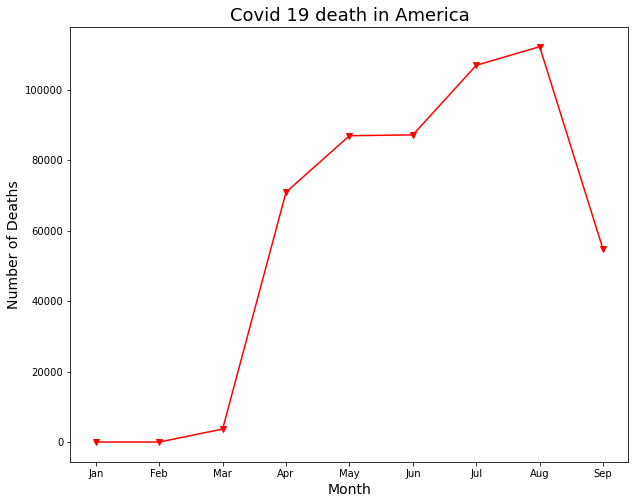

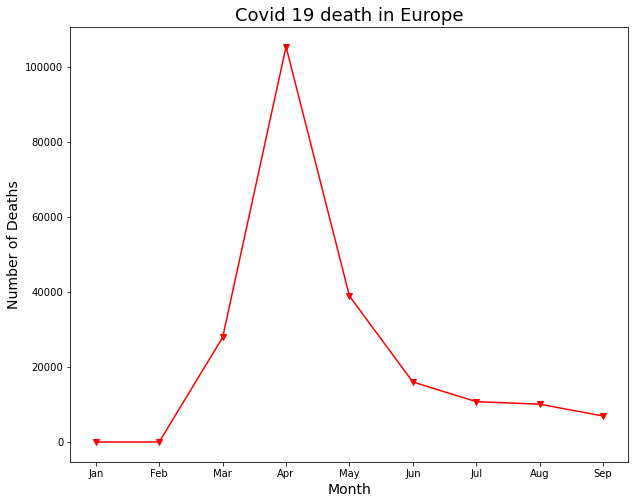

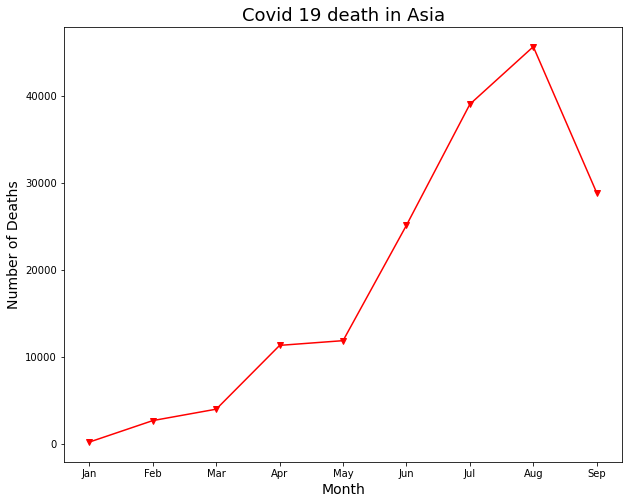

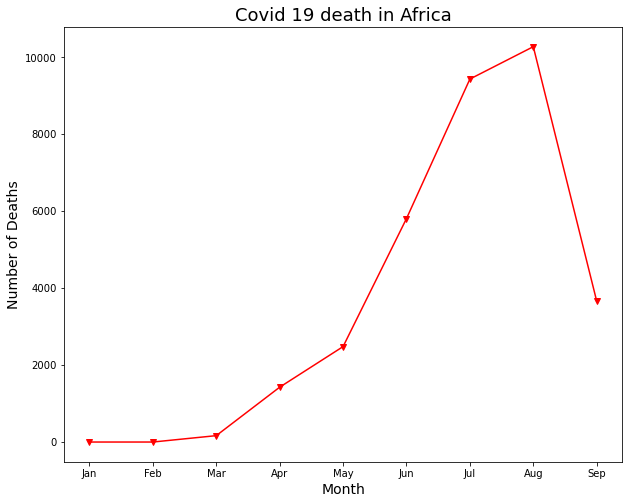

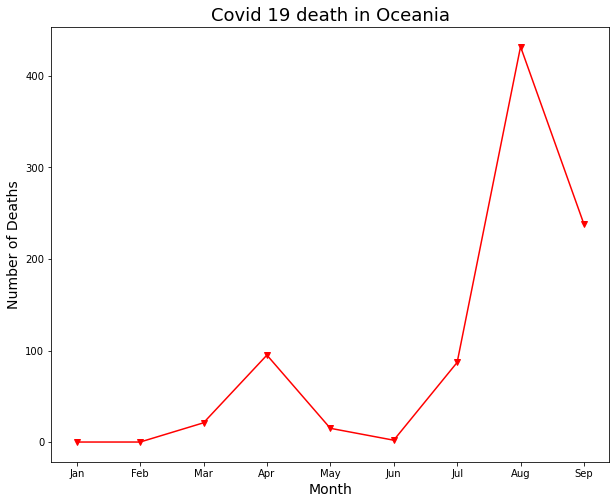

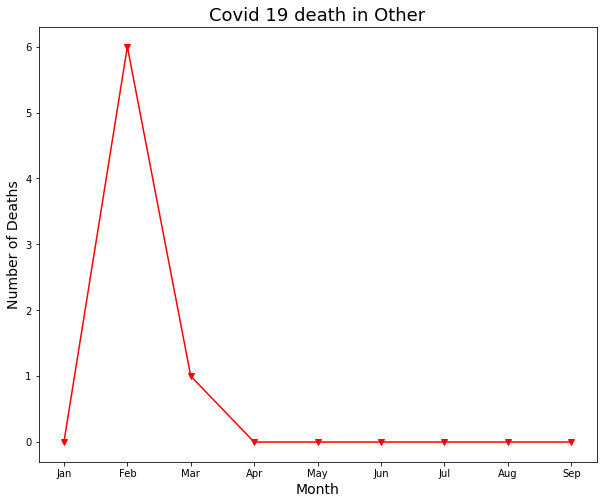

In [29]:
#plotting the number of death in each month relative per continent
for col in deaths_per_month_per_continent.columns: 
    fig, ax = plt.subplots(figsize = (10, 8))
    ax.plot(deaths_per_month_per_continent.index, deaths_per_month_per_continent[col], marker = 'v', color = 'r', )
    ax.set_xlabel('Month', fontsize = 14)
    ax.set_ylabel('Number of Deaths', fontsize = 14)
    ax.set_title('Covid 19 death in '+str(col), fontsize = 18)

### Country wide reported cases

In [30]:
cases_and_deaths_in_each_country = data.groupby('countriesAndTerritories')['cases', 'deaths'].sum()

In [31]:
cases_and_deaths_in_each_country['Mortality Rate (per 100)'] = np.round(100 * cases_and_deaths_in_each_country['deaths']/cases_and_deaths_in_each_country['cases'], 2)

In [32]:
cases_and_deaths_in_each_country.sort_values('cases', ascending = False).style.background_gradient(cmap='Blues', subset=['cases'])\
                        .background_gradient(cmap='Reds',subset=["deaths"])\
                        .background_gradient(cmap='YlOrBr',subset=["Mortality Rate (per 100)"])\


,cases,deaths,Mortality Rate (per 100)
countriesAndTerritories,,,
United_States_of_America,6630891,196802,2.970000
India,5118253,83198,1.630000
Brazil,4419083,134106,3.030000
Russia,1079519,18917,1.750000
Peru,744400,31051,4.170000
Colombia,736377,23478,3.190000
Mexico,680931,71978,10.570000
South_Africa,653444,15705,2.400000
Spain,614360,30243,4.920000


### Top 15 countries with confirmed cases and confirmed death

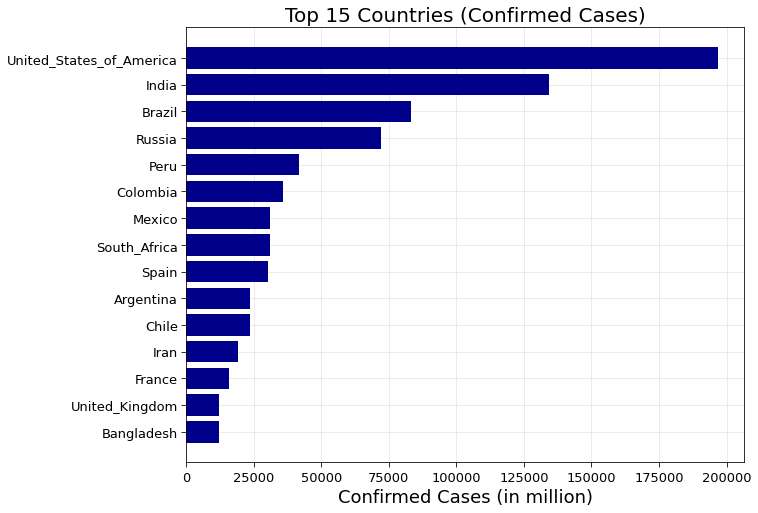

In [33]:
f = plt.figure(figsize=(10,8))
f.add_subplot(111)
plt.axes(axisbelow=True)
plt.barh(cases_and_deaths_in_each_country.sort_values('cases', ascending=False).index[:15], cases_and_deaths_in_each_country.sort_values('deaths', ascending=False)['deaths'][:15], color="darkblue")
plt.gca().invert_yaxis()
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Confirmed Cases (in million)",fontsize=18)
plt.title("Top 15 Countries (Confirmed Cases)",fontsize=20)
plt.grid(alpha=0.3)


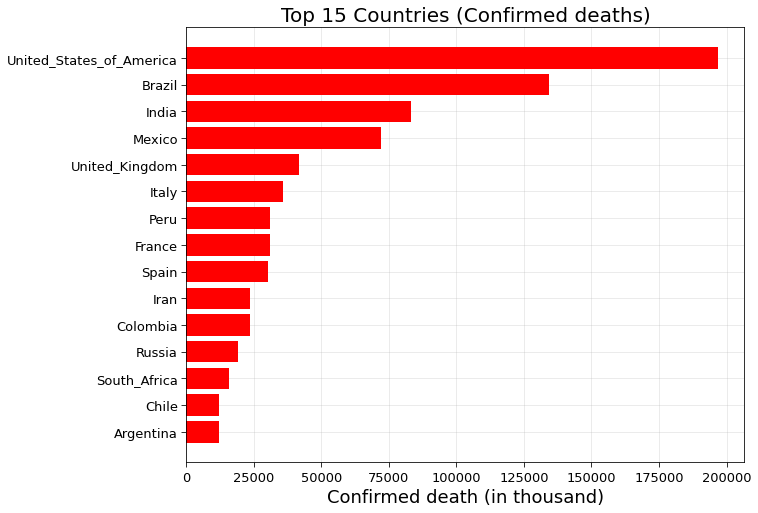

In [34]:
f = plt.figure(figsize=(10,8))
f.add_subplot(111)
plt.axes(axisbelow=True)
plt.barh(cases_and_deaths_in_each_country.sort_values('deaths', ascending=False).index[:15], cases_and_deaths_in_each_country.sort_values('deaths', ascending=False)['deaths'][:15], color="red")
plt.gca().invert_yaxis()
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Confirmed death (in thousand)",fontsize=18)
plt.title("Top 15 Countries (Confirmed deaths)",fontsize=20)
plt.grid(alpha=0.3)

### Correlation analysis for countries

In [35]:
cases_and_deaths_in_each_country.loc[:,:].corr().style.background_gradient(cmap='RdBu_r').format("{:.3f}")

,cases,deaths,Mortality Rate (per 100)
cases,1.000,0.934,0.044
deaths,0.934,1.000,0.178
Mortality Rate (per 100),0.044,0.178,1.000


### Correlation analysis for continent

In [36]:
death_and_cases_per_continent.corr().style.background_gradient(cmap='RdBu_r').format("{:.3f}")

,cases,deaths,Mortality Rate (per 100)
cases,1.000,0.947,0.284
deaths,0.947,1.000,0.494
Mortality Rate (per 100),0.284,0.494,1.000


### Confirmed Covid19 cases in each country 

In [37]:
#reset index first and rename the countriesandTerritories column to Country
cases_and_deaths_in_each_country = cases_and_deaths_in_each_country.reset_index().rename(columns= {'countriesAndTerritories' : 'Country'})

In [38]:
#Create country code from column
cases_and_deaths_in_each_country['Country_code'] = cases_and_deaths_in_each_country['Country'].apply(lambda x: x[:3].upper())

In [39]:
cc = coco.CountryConverter()

In [40]:
cases_and_deaths_in_each_country['Country_code'] = cases_and_deaths_in_each_country['Country'].apply(lambda x: cc.convert(names = x, to = 'ISO3'))

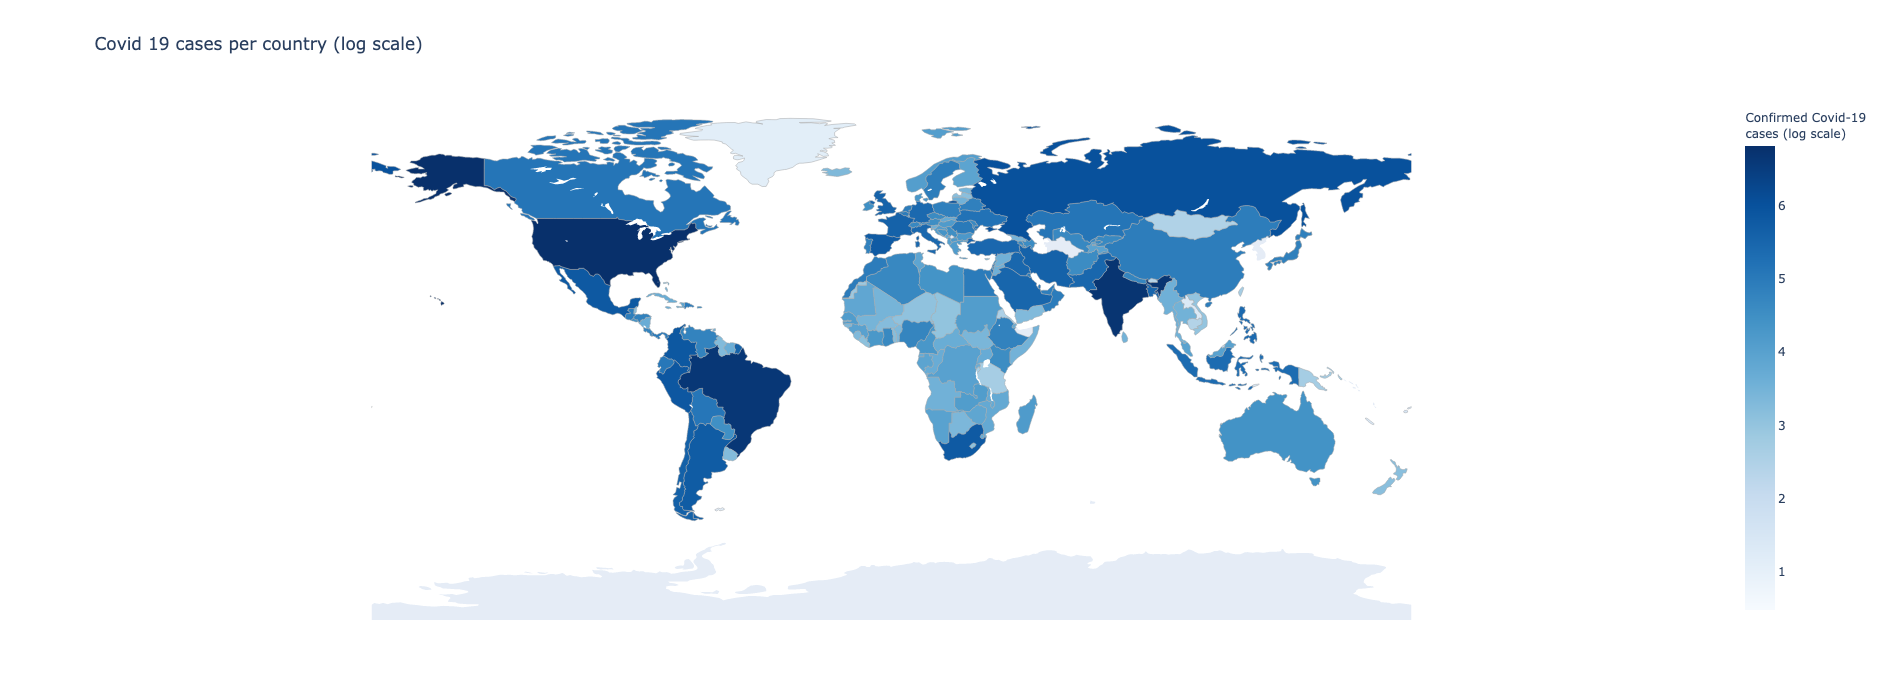

In [72]:
#figure for map
fig = go.Figure(data = go.Choropleth(locations = cases_and_deaths_in_each_country['Country_code'], z = np.log10(cases_and_deaths_in_each_country['cases']), colorscale = 'Blues', \
                                    hoverinfo='all',text = cases_and_deaths_in_each_country['Country'],colorbar_title = 'Confirmed Covid-19<br>cases (log scale)', marker_line_color = 'darkgray', \
                                    marker_line_width = 0.5))
fig.update_layout(title_text = 'Covid 19 cases per country (log scale)', geo=dict(showframe=False, showcoastlines=False, projection_type='equirectangular'), width = 1500, height = 700)
iplot(fig)

### Confirmed covid19 deaths in each country

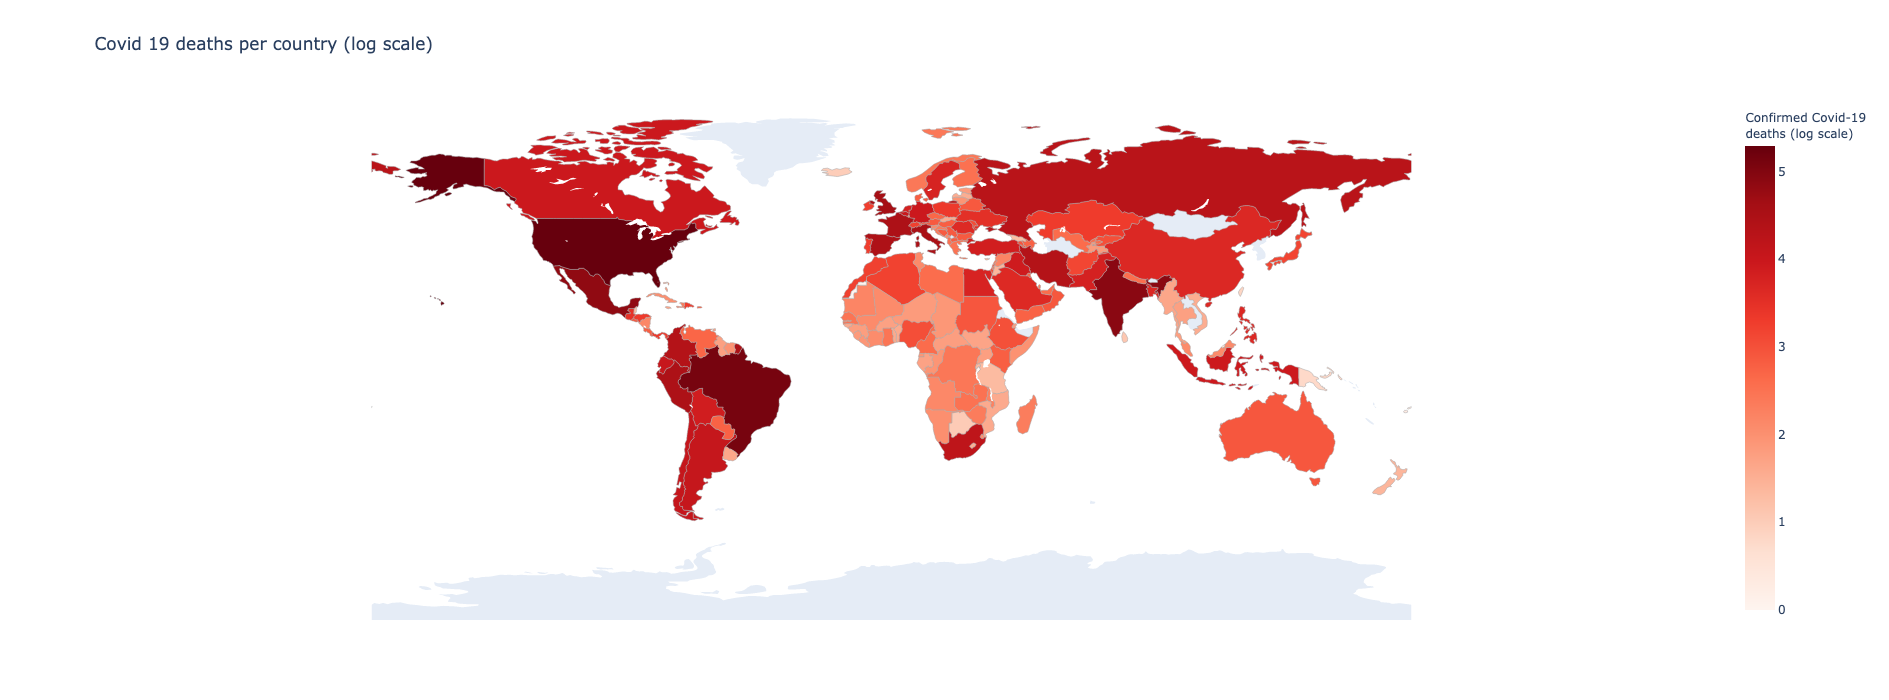

In [71]:
fig = go.Figure(data = go.Choropleth(locations = cases_and_deaths_in_each_country['Country_code'], z = np.log10(cases_and_deaths_in_each_country['deaths']), colorscale = 'Reds', \
                                    hoverinfo='all', hovertext=cases_and_deaths_in_each_country['Country'], colorbar_title = 'Confirmed Covid-19<br>deaths (log scale)', marker_line_color = 'darkgray', \
                                    marker_line_width = 0.5))
fig.update_layout(title_text = 'Covid 19 deaths per country (log scale)', geo=dict(showframe=False, showcoastlines=False, projection_type='equirectangular'), width = 1500, height = 700)
iplot(fig)